## Finilizing Data Generation for PSR System

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerRestTrain      = 1000
tStratch           = 1.
NtTrain            = NPerRestTrain*2
SOLVER             = 'BDF'

ValidPerc          = 20.

In [3]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))

FileName     = OutputDir + '/Orig/train/ext/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
# FileName     = OutputDir+'/orig_data/t.csv'
# Data         = pd.read_csv(FileName, header=None)
# tVec         = Data.to_numpy()[:,0]

# FileName     = OutputDir + '/orig_data/yCleaned.csv'
# yMatOrig     = pd.read_csv(FileName, header=0)
# VarNames     = list(yMatOrig.columns)
# yMat         = yMatOrig.to_numpy()

FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv'
Data                 = pd.read_csv(FileName, header=0)
Data['log10(t)']     = np.log10(Data.t.to_numpy()+1.e-15)
Data['log10(Rest)']  = RestVecTot
Data['Rest']         = 10.**RestVecTot
yMat_pca             = Data[Vars].to_numpy()

FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PCSource.csv'
DataS                = pd.read_csv(FileName, header=0)
DataS['log10(t)']    = np.log10(Data.t.to_numpy()+1.e-15)
DataS['log10(Rest)'] = RestVecTot
DataS['Rest']        = 10.**RestVecTot
ySource_pca          = DataS[SVars].to_numpy()


### Writing Input
InputVar     = ['t', 'log10(t)', 'Rest', 'log10(Rest)']
DataInput    = Data[InputVar]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/Input.csv', index=False)
tVec         = DataInput.t.to_numpy()


### Writing PCs
Data.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/Output.csv', index=False)


### Normalizing PCs' Source Terms
yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
yScale       = np.concatenate([yMin[...,np.newaxis], yMax[...,np.newaxis]], axis=1)
np.savetxt(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/MinMax.csv', yScale, header='Min,Max', comments='', delimiter=',')

ySourcee_pca = (ySource_pca - yMin)/yRange
#ySourcee_pca = (ySource_pca - yMin)/yRange[0]

for iPC in range(NVarsRed):
    DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
DataS.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/dOutput.csv', index=False)

Text(0.5, 0, '$dPC_3/dt$')

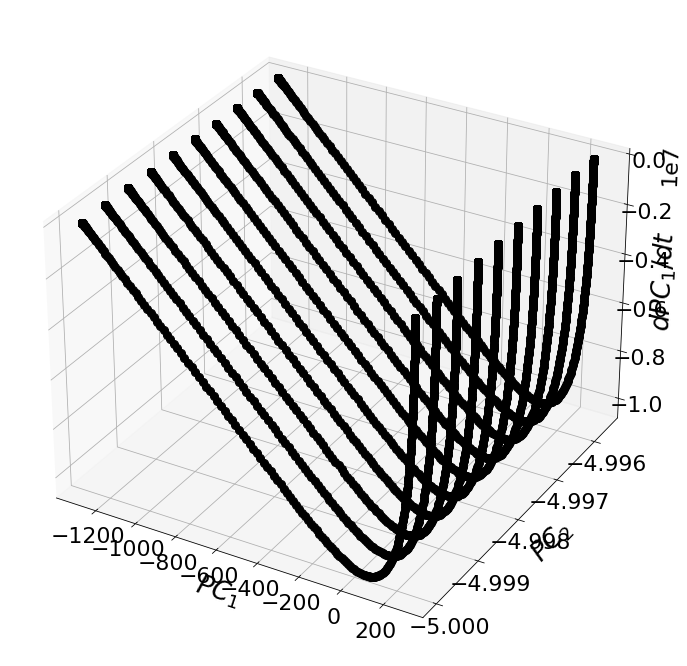

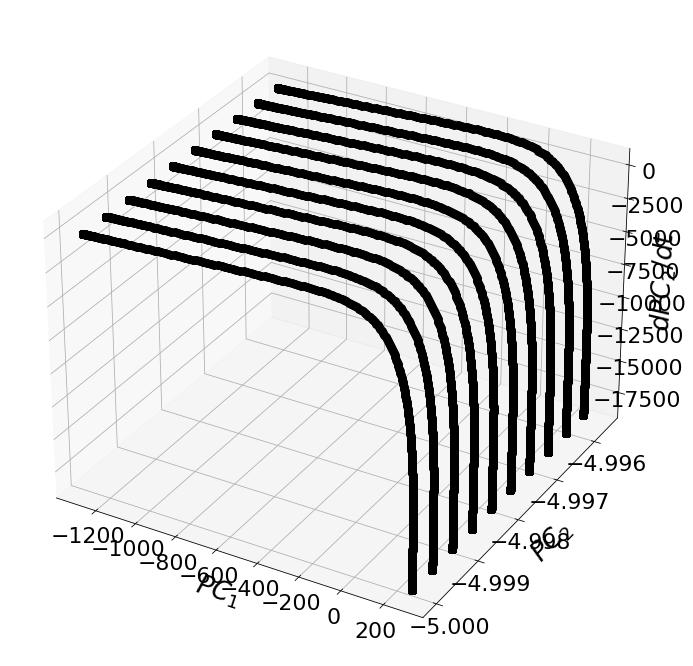

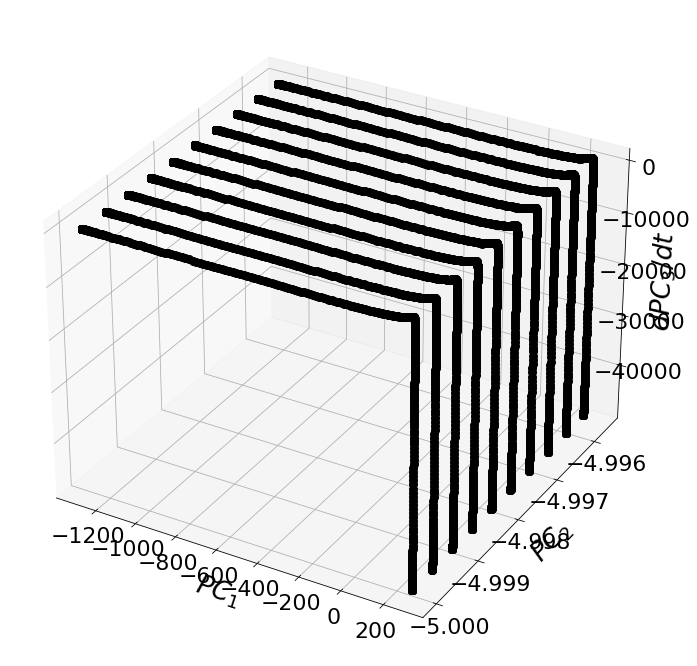

In [4]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

Text(0.5, 0, '$dPC_3/dt$')

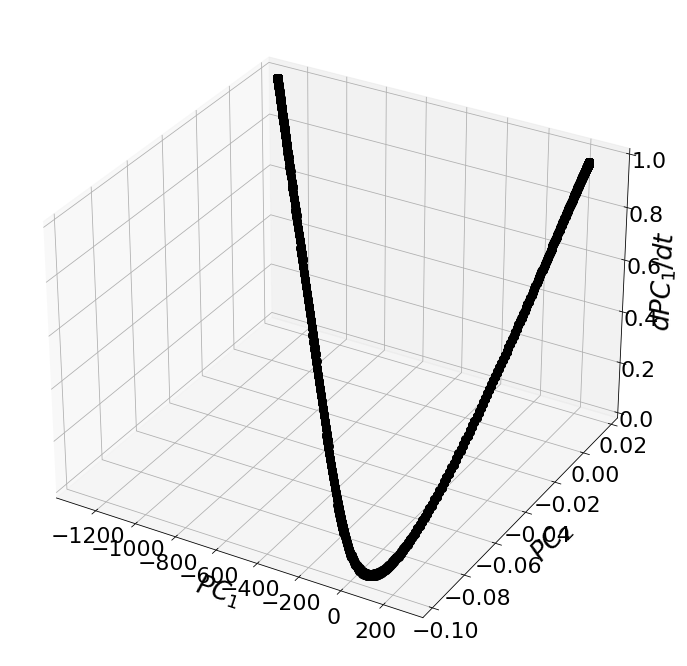

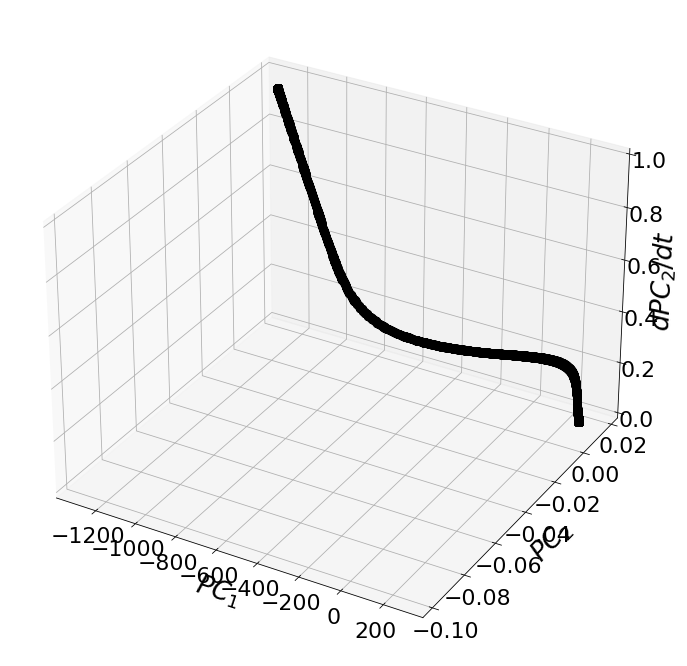

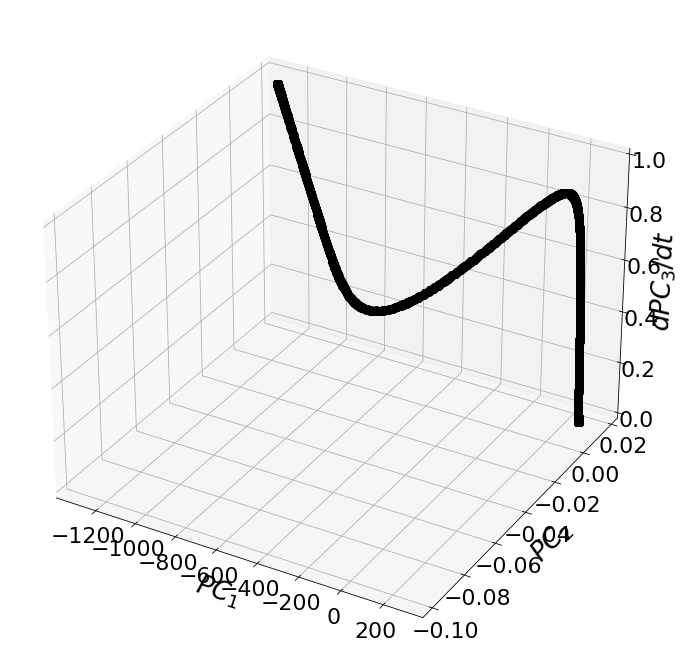

In [5]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

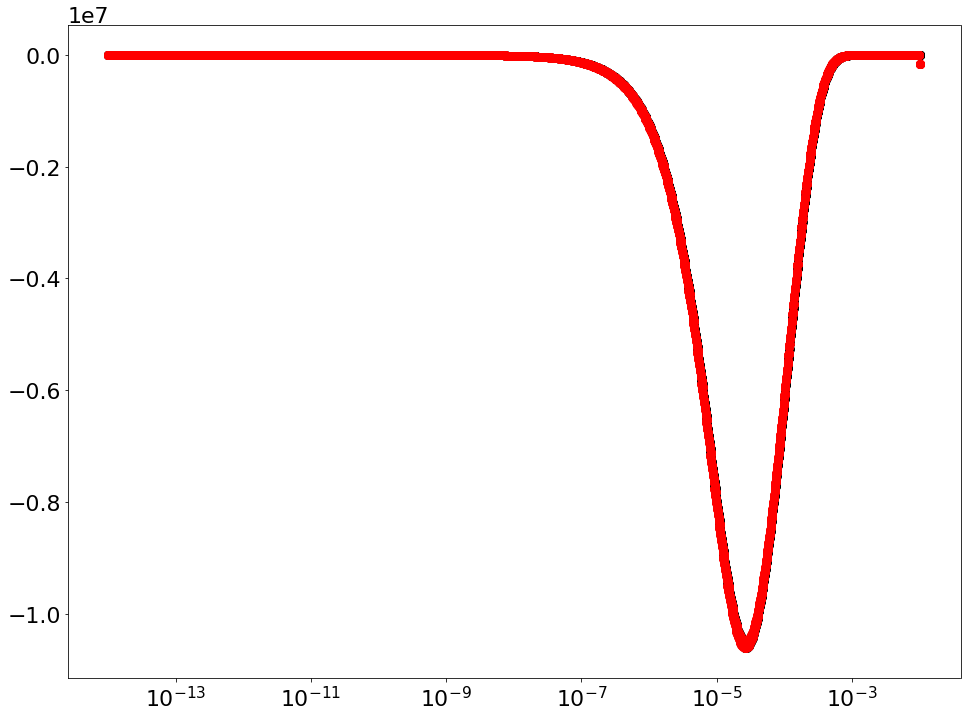

In [6]:
### Checking Data

from numpy import diff

iPC = 0

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[0:-1], dydt, 'ro')
plt.xscale('log')

In [7]:
from sklearn.model_selection import train_test_split

n_points             = len(Data)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/')
except:
    pass

In [8]:
data_id    = 'pts'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

DataInput  = Data[['t', 'log10(Rest)']]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput = Data[['t'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [9]:
data_id    = 'res'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

DataInput  = Data[['t', 'log10(Rest)']]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = Data[['t'] + Vars]
DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

<ipython-input-9-d771c2354682>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [10]:
data_id = 'ics'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

Data_ics                     = Data[Data['t'] == 0.]
n_points_ics                 = len(Data_ics)
idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=ValidPerc/100, random_state=42)

DataInput      = Data_ics[['t', 'log10(Rest)']]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = Data_ics[['t'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [11]:
# ### Retrieving Data

# Vars = []
# for iVars in range(1,NVarsRed+1):
#     Vars.append('PC_'+str(iVars))

# SVars = []
# for iVars in range(1,NVarsRed+1):
#     SVars.append('SPC_'+str(iVars))

# FileName     = TestDir + '/orig_data/RestVecTot.csv'
# Data         = pd.read_csv(FileName, header=None)
# RestVecTot   = np.log10(Data.to_numpy())
    
# # FileName     = TestDir+'/orig_data/t.csv'
# # Data         = pd.read_csv(FileName, header=None)
# # tVec         = Data.to_numpy()[:,0]

# # FileName     = TestDir + '/orig_data/yCleaned.csv'
# # yMatOrig     = pd.read_csv(FileName, header=0)
# # VarNames     = list(yMatOrig.columns)
# # yMat         = yMatOrig.to_numpy()

# FileName             = TestDir+'/'+str(NVarsRed)+'PC/PC.csv'
# Data                 = pd.read_csv(FileName, header=0)
# Data['log10(t)']     = np.log10(Data.t.to_numpy()+1.e-15)
# Data['log10(Rest)']  = RestVecTot
# Data['Rest']         = 10.**RestVecTot
# yMat_pca             = Data[Vars].to_numpy()

# FileName             = TestDir+'/'+str(NVarsRed)+'PC/PCSource.csv'
# DataS                = pd.read_csv(FileName, header=0)
# DataS['log10(t)']    = np.log10(Data.t.to_numpy()+1.e-15)
# DataS['log10(Rest)'] = RestVecTot
# DataS['Rest']        = 10.**RestVecTot
# ySource_pca          = DataS[SVars].to_numpy()


# ### Writing Input
# InputVar     = ['t', 'log10(t)', 'Rest', 'log10(Rest)']
# DataInput    = Data[InputVar]
# DataInput.to_csv(TestDir+'/'+str(NVarsRed)+'PC/Input.csv', index=False)
# tVec         = DataInput.t.to_numpy()


# ### Writing PCs
# Data.to_csv(TestDir+'/'+str(NVarsRed)+'PC/Output.csv', index=False)


# ### Normalizing PCs' Source Terms
# ySourcee_pca = (ySource_pca - yMin)/yRange
# #ySourcee_pca = (ySource_pca - yMin)/yRange[0]

# for iPC in range(NVarsRed):
#     DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
# DataS.to_csv(TestDir+'/'+str(NVarsRed)+'PC/dOutput.csv', index=False)